In [1]:
%reload_ext autoreload
%autoreload 2

In [90]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.base_ae import BaseAutoEncoder
from dsin.ae.si_autoenc import SideInformationAutoEncoder

from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config


In [91]:
config.H_target = 2* 0.3
# config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.K_MS_SSIM=500
config.beta

500

# Load Critic Dataset

In [92]:
def get_crit_data(bs= 32, size=(336, 336)):
    path = "../src/dsin"
 
    kitti_stats = ([0.367, 0.385, 0.372], [0.288, 0.298, 0.301]) # mean, std

    data_image = (ImageList.from_csv(path=path, cols = 'name', csv_name = 'DISC_KITTI_TOT.txt')
                     .split_by_rand_pct(0.1, seed=42)
                     .label_from_df(cols='label')
                     .transform(None, size=size, resize_method=ResizeMethod.CROP)
                     .databunch(bs=bs)
                     .normalize(kitti_stats))
    #     data_image.c = 3
    data_image
    return data_image

In [93]:
# data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

data_crit = get_crit_data(bs = 4)

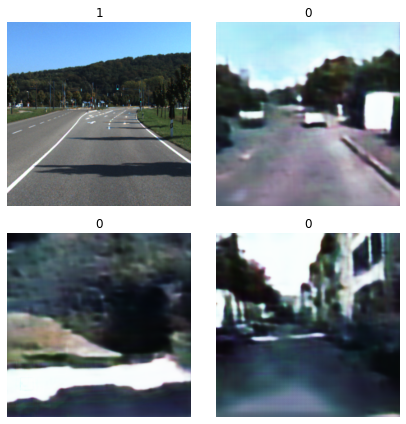

In [6]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)


In [181]:
class CapturingAdaptiveLoss(nn.Module):
    def __init__(self, crit): 
        super().__init__()
        self.crit = crit
        self.loss_critic_val = 1.0
        
    def forward(self, output, target:bool):
        targ = output.new_ones(*output.size()) if target else output.new_zeros(*output.size())
        self.loss_critic_val = self.crit(output, targ)
        return self.loss_critic_val


In [182]:
loss_critic = CapturingAdaptiveLoss(nn.BCEWithLogitsLoss())


# Create Critic

In [95]:
class SiCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = gan_critic()
    def forward(self,*vargs,**kwargs):
#         import pdb
#         pdb.set_trace()
        return self.model(vargs[0])
        #if len(args) == 1: # assume single image input
        #if len(args) == 6 : # output from si_autoenv with loss variables then 0 position is x_reconstructed
            
            
            
        
    

In [96]:
wd = 1e-3

In [97]:

learn_critic = Learner(data_crit, SiCritic(), metrics=accuracy_thresh_expand, loss_func=loss_critic, wd=wd)

In [ ]:
learn_critic.fit_one_cycle(4, 1e-3)


In [ ]:
input()

In [ ]:
! ls ../src/dsin/models

In [17]:
model_fname = '20200818-critic-pre-gan'
learn_critic.save(model_fname)
!aws s3 cp ~/tDSIN/src/dsin/models/{model_fname}.pth  s3://dsin-us/models/


upload: ../src/dsin/models/20200818-critic-pre-gan.pth to s3://dsin-us/models/20200818-critic-pre-gan.pth


#  METRIC

In [192]:
class AverageMetric(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self, func,name):
        # If it's a partial, use func.func
        #         name = getattr(func,'func',func).__name__
        self.func, self.name = func, name

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
        if not is_listy(last_target): last_target=[last_target]
        self.count += last_target[0].size(0) # batch size
        
        if last_output[0] is None:
            X_OUTPUT = 1 # X_DEC
        else:
            X_OUTPUT = 0 # X_HAT_OUT
        val = self.func(last_output[X_OUTPUT], last_target[0])
        self.val += last_target[0].size(0) * val.detach().cpu()
        
    
    
    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val/self.count)
    
class ParameterMetricCallback(Callback):
    def __init__(self,loss_man):
        self.loss_man = loss_man
    
    def on_backward_begin(self,*args, **kwargs):
        self.pbar=kwargs["pbar"]
        if hasattr(self.loss_man,'soft_bit_entropy'):
            self.pbar.child.comment += f' soft_bit_entropy: {self.loss_man.soft_bit_entropy:.4f}'
            
            
class GenLogger(Callback):
    def __init__(self,learner, loss_man,attrs):
        self.loss_man = loss_man
        self.attrs = attrs
    def on_backward_begin(self,*args, **kwargs):
        self.pbar=kwargs["pbar"]
        msg = ""
        
        for attr in self.attrs:
            msg += f"{attr}={getattr(self.loss_man,attr,None):.2f} "
        self.pbar.child.comment += msg
        
        
        
         
class ParameterRunningAverageMetricCallback(Callback):
    def __init__(self,loss_man,alpha=0.1):
        self.loss_man = loss_man
        self.alpha = alpha
        self.val = None
    
    def on_backward_begin(self,*args, **kwargs):
        self.pbar=kwargs["pbar"]
        self.importance_map=self.loss_man.importnace_map_dict
#         import pdb
#         pdb.set_trace()
        if hasattr(self.loss_man,'soft_bit_entropy'):
            if self.val is None:
                self.val = self.loss_man.soft_bit_entropy.detach()
            else:
                self.val *= 1 - self.alpha
                self.val += self.alpha * self.loss_man.soft_bit_entropy.detach()
                
            self.pbar.child.comment += f' avg_bpp: {self.val / 2 :.4f} imp{self.importance_map["mean"]:.2f}{self.importance_map["var"]:.2f}'
            msg = f"bitcost_loss={self.loss_man.bit_cost_loss_value:.1f} "
            msg += f"l2reg_loss={self.loss_man.l2_reg_loss:.1f} "
            msg += f"autoencoder_loss_value={ self.loss_man.autoencoder_loss_value:.1f} "
            msg += f"si_loss={self.loss_man.si_net_loss_value:.1f} "
            msg += f"feat_loss_value={self.loss_man.feat_loss_value:.1f}"

            self.pbar.child.comment += msg
            
class ParameterRunningAverageMetricCallback2(ParameterRunningAverageMetricCallback) :
     def __init__(self,learn, loss_man,alpha=0.1,*args,**kwargs):
             super().__init__(loss_man,alpha)

2020-08-21


In [ ]:


model_fname = f'{now_date}MAE-l2reg-res-si-nofeatloss'
for i in range(1,4):
    if i != 1 :
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    
    config.si_loss_weight_alpha = 0.7
    learn.model.true_tuple_loss_false_just_out = True
    learn.model.use_side_infomation = SiNetChannelIn.WithSideInformation
    learn.loss_func.use_side_infomation = SiNetChannelIn.WithSideInformation
    learn.fit(1, lr=0.0001,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func)])
    learn.save(f'{model_fname}-{i}')
    !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
    !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}-{i}.log

# GAN

In [204]:
learn_critic=None
learn_gen = None
gc.collect()

2150

In [205]:
data_crit = get_crit_data(bs = 1)
learn_critic =(Learner(data_crit, SiCritic(), metrics=None, loss_func=loss_critic, wd=wd)
               .load('20200818-critic-pre-gan'))


In [206]:

baseae_path = "../src/dsin/data"
pct= 1 #0.0005 #0.25
valid_image_list = SideinformationImageImageList.from_csv(
    path=baseae_path, csv_names=["KITTI_stereo_val.txt"],pct=pct/10)
train_image_list = SideinformationImageImageList.from_csv(
    path=baseae_path, csv_names=["KITTI_stereo_train.txt"],pct=pct)

baseae_image_lists = ItemLists(
    path=baseae_path, train=train_image_list, valid=valid_image_list)

batchsize = 1

baseae_data = (baseae_image_lists
        .label_from_func(lambda x: x)
        .transform(None, size=(336, 336), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))

In [207]:
si_autoencoder = SideInformationAutoEncoder(base_line_auto_enc = BaseAutoEncoder())

learn_gen = Learner(data=baseae_data,
                     model=si_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(si_autoencoder,SiNetChannelIn.WithSideInformation,use_feat_loss=False), #True
                     ).load('200816MAE-l2reg-res-si-new-normalize-4')


In [208]:
learn_gen.layer_groups




[Sequential(
   (0): Sigmoid()
   (1): Conv2d(3, 64, kernel_size=[5, 5], stride=[2, 2], padding=[2, 2], padding_mode=replicate)
   (2): ReLU()
   (3): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (4): Conv2d(64, 128, kernel_size=[5, 5], stride=[2, 2], padding=[2, 2], padding_mode=replicate)
   (5): ReLU()
   (6): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (7): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)
   (8): ReLU()
   (9): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (10): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)
   (11): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)
   (12): ReLU()
   (13): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (14): Conv2d(128, 128, kernel_size=[3, 3], stride=[

In [209]:

@dataclass
class MyAdaptiveGANSwitcher(LearnerCallback):
    "Switcher that goes back to generator/critic when the loss goes below `gen_thresh`/`crit_thresh`."
    def __init__(self, learn:Learner):
        super().__init__(learn)
        self.count, self.thresh = 0, 30
        
    def on_batch_end(self, last_loss, **kwargs):
        "Switch the model if necessary."
        if self.count % self.thresh == 0:
            self.count = 0
            self.gan_trainer.switch()
        self.count += 1

In [210]:
switcher = MyAdaptiveGANSwitcher #partial(AdaptiveGANSwitcher, critic_thresh=0.65)
gan_learn = GANLearner.from_learners(learn_gen, learn_critic, weights_gen=(50.,1.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
gan_learn.callback_fns.append(partial(ParameterRunningAverageMetricCallback2,loss_man=learn_gen.loss_func, alpha =0.1))
gan_learn.callback_fns.append(partial(GenLogger, loss_man=learn_critic.loss_func,attrs=['loss_critic_val']))
gan_learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [211]:
lr = 1e-4

In [212]:
gan_learn.fit(6,lr)


epoch,train_loss,valid_loss,gen_loss,disc_loss,time


KeyboardInterrupt: 

In [ ]:
mt =torch.load('vargs1').detach()[0,...]
show_image(Image(mt),figsize=(10,10))


In [18]:
learn.save('gan-1c')


NameError: name 'learn' is not defined

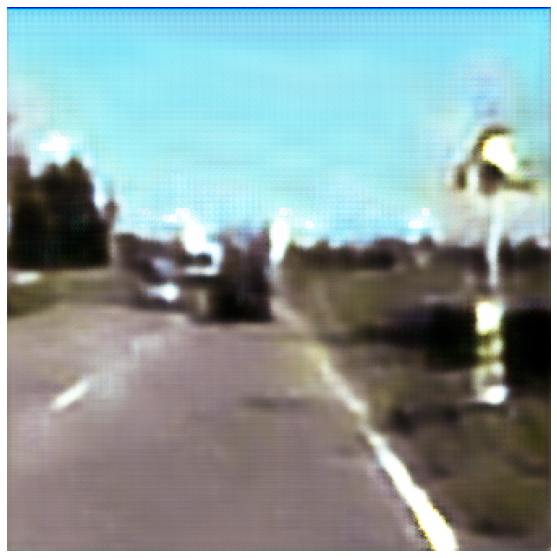

In [202]:
mt = learn_gen.model.my_tuple[3].detach()[0,...]

show_image(Image(mt),figsize=(10,10))


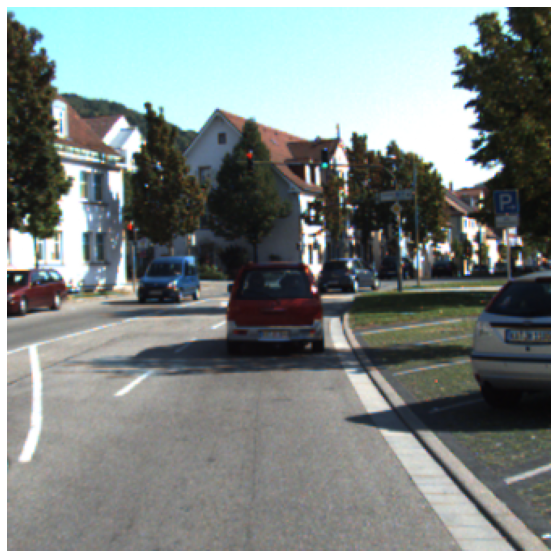

In [145]:
mt = learn_gen.model.my_tuple[-3].squeeze_().detach()

show_image(Image(mt),figsize=(10,10))
